In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def n_body_with_drag(t, x, p):
    """
    ODE function for n-body problem with drag resistance

    Parameters:
    t (float): time
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - drag_coeff (float): drag coefficient

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)
    drag_coeff = p.get('drag_coeff', 0)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # Calculate gravitational forces
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle
            # Calculate displacement vector between bodies i and j
            r_ij = []
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                r_ij.append(displacement)

            r_ij = np.array(r_ij)

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # Calculate total forces and drag
    for i in range(n_bodies):
        # Calculate total gravitational force components
        for d in range(dimensions):
            total_grav_force = np.sum(force_matrices[d][i])

            # Calculate velocity for drag calculation
            velocity = x[n_bodies*dimensions + i*dimensions + d]

            # Calculate drag force (proportional to velocity squared)
            drag_force = -drag_coeff * velocity * np.abs(velocity)

            # Total force (gravitational + drag)
            total_force = total_grav_force + drag_force

            # Calculate acceleration
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]

    return dxdt

Circular orbit velocity: 6.283185307179586


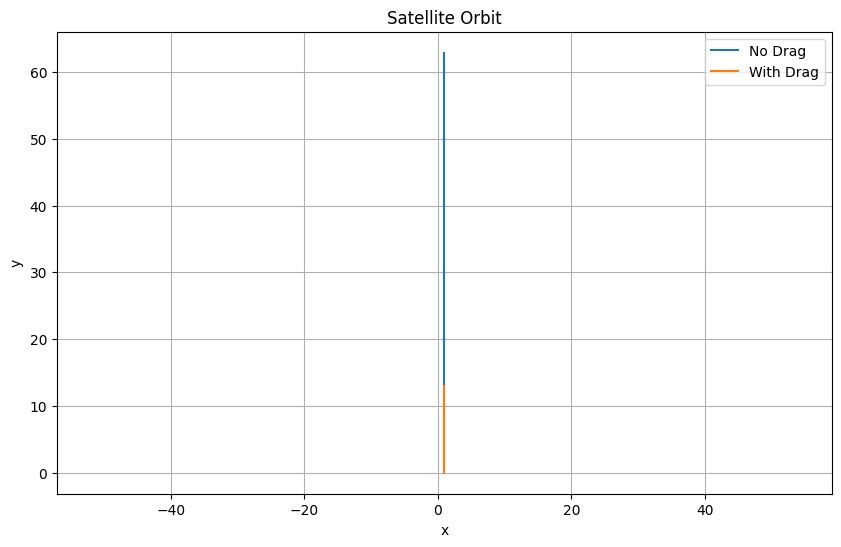

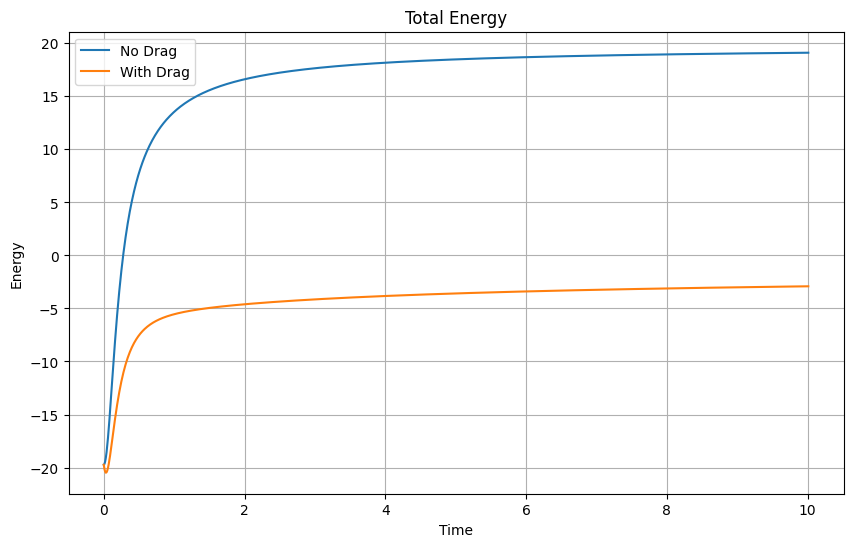

In [ ]:
# Circular orbit velocity calculation
r = 1.0  # 1 AU
GM = 4 * np.pi**2  # Astronomical units

# Circular orbit velocity
v_circular = np.sqrt(GM / r)
print(f"Circular orbit velocity: {v_circular}")

# Initial conditions for a circular orbit: x, y, vx, vy
y0_no_drag = [1, 0, 0, v_circular]
y0_with_drag = [1, 0, 0, v_circular]

# Parameters
p_no_drag = {
    'm': [1],  # satellite mass
    'G': GM,   # Correctly using 4π²
    'dimension': 2,
    'drag_coeff': 0  # No drag
}

p_with_drag = {
    'm': [1],  # satellite mass
    'G': GM,   # Correctly using 4π²
    'dimension': 2,
    'drag_coeff': 0.2  # Drag coefficient (adjustable)
}

# Time span
t_span = [0, 10]  # 10 time units

# Solve ODE with no drag
t_no_drag, y_no_drag = solve_ode(n_body_with_drag, t_span, y0_no_drag,
                                  EulerRichardson, p_no_drag, first_step=0.01)

# Solve ODE with drag
t_drag, y_drag = solve_ode(n_body_with_drag, t_span, y0_with_drag,
                            EulerRichardson, p_with_drag, first_step=0.01)

# Orbital Trajectory Plot
plt.figure(figsize=(10,6))
plt.plot(y_no_drag[:,0], y_no_drag[:,1], label='No Drag')
plt.plot(y_drag[:,0], y_drag[:,1], label='With Drag')
plt.title('Satellite Orbit')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

# Energy calculation function
def calculate_energy(t, y, p):
    x, y, vx, vy = y[0], y[1], y[2], y[3]
    r = np.sqrt(x**2 + y**2)
    kinetic_energy = 0.5 * (vx**2 + vy**2)
    potential_energy = -p['G'] / r
    return kinetic_energy + potential_energy

# Energy Plot
plt.figure(figsize=(10,6))
energy_no_drag = [calculate_energy(t, y, p_no_drag) for t, y in zip(t_no_drag, y_no_drag)]
energy_drag = [calculate_energy(t, y, p_with_drag) for t, y in zip(t_drag, y_drag)]

plt.plot(t_no_drag, energy_no_drag, label='No Drag')
plt.plot(t_drag, energy_drag, label='With Drag')
plt.title('Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

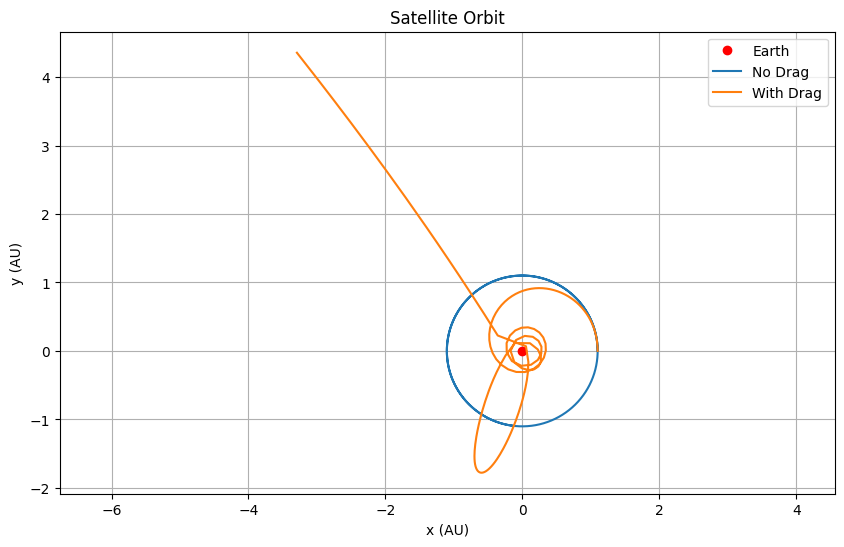

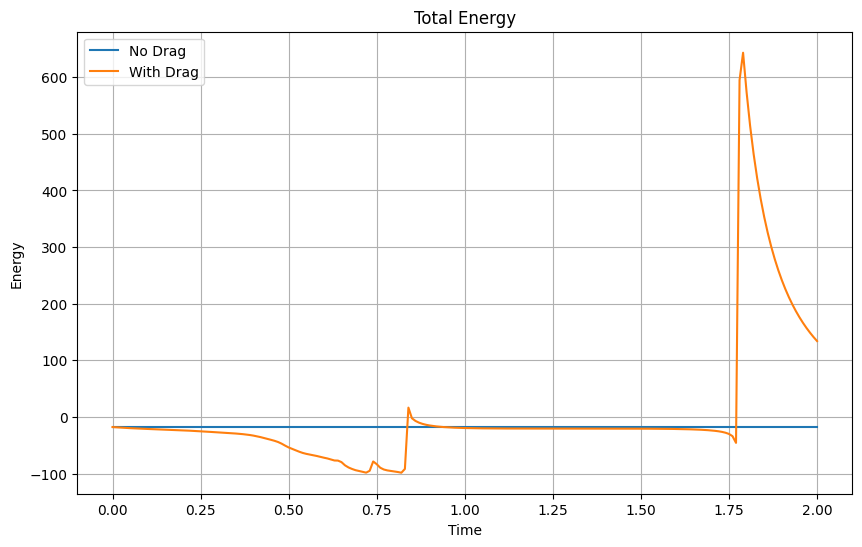

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solver import solve_ode, EulerRichardson

def n_body_with_drag(t, x, p):
    """
    ODE function for satellite orbit with drag resistance

    Parameters:
    t (float): time
    x (np.array): state vector [x, y, vx, vy]
    p (dict): parameters dictionary

    Returns:
    np.array: derivative of state vector [vx, vy, ax, ay]
    """
    # Extract parameters
    G = p['G']
    drag_coeff = p.get('drag_coeff', 0)

    # Unpack state
    x_pos, y_pos, vx, vy = x

    # Calculate distance from Earth (origin)
    r = np.sqrt(x_pos**2 + y_pos**2)

    # Gravitational acceleration
    grav_accel_x = -G * x_pos / (r**3)
    grav_accel_y = -G * y_pos / (r**3)

    # Drag acceleration (proportional to velocity squared)
    drag_accel_x = -drag_coeff * vx * np.abs(vx)
    drag_accel_y = -drag_coeff * vy * np.abs(vy)

    # Combine accelerations
    ax = grav_accel_x + drag_accel_x
    ay = grav_accel_y + drag_accel_y

    # Return derivatives [vx, vy, ax, ay]
    return np.array([vx, vy, ax, ay])

# Gravitational constant in AU³/(year²)
G = 4 * np.pi**2  # Astronomical units convention

# Initial conditions
# Satellite at 1.1 AU from Earth, circular orbit
r = 1.1  # distance in AU
# Circular orbit velocity
v_circular = np.sqrt(G / r)

# Initial conditions: x, y, vx, vy
y0_no_drag = [r, 0, 0, v_circular]
y0_with_drag = [r, 0, 0, v_circular]

# Parameters
p_no_drag = {
    'G': G,
    'drag_coeff': 0  # No drag
}

p_with_drag = {
    'G': G,
    'drag_coeff': 0.2  # Drag coefficient
}

# Time span
t_span = [0, 2]  # 10 time units

# Solve ODE with no drag
t_no_drag, y_no_drag = solve_ode(n_body_with_drag, t_span, y0_no_drag,
                                  EulerRichardson, p_no_drag, first_step=0.01)

# Solve ODE with drag
t_drag, y_drag = solve_ode(n_body_with_drag, t_span, y0_with_drag,
                            EulerRichardson, p_with_drag, first_step=0.01)

# Orbital Trajectory Plot
plt.figure(figsize=(10,6))
# Plot Earth at origin
plt.plot(0, 0, 'ro', label='Earth')
plt.plot(y_no_drag[:,0], y_no_drag[:,1], label='No Drag')
plt.plot(y_drag[:,0], y_drag[:,1], label='With Drag')
plt.title('Satellite Orbit')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

# Energy calculation function
def calculate_energy(y, p):
    x, y, vx, vy = y
    r = np.sqrt(x**2 + y**2)
    kinetic_energy = 0.5 * (vx**2 + vy**2)
    potential_energy = -p['G'] / r
    return kinetic_energy + potential_energy

# Energy Plot
plt.figure(figsize=(10,6))
energy_no_drag = [calculate_energy(y, p_no_drag) for y in y_no_drag]
energy_drag = [calculate_energy(y, p_with_drag) for y in y_drag]

plt.plot(t_no_drag, energy_no_drag, label='No Drag')
plt.plot(t_drag, energy_drag, label='With Drag')
plt.title('Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()